In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('./utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)

##shapes are n_fish, max_n_bouts,dim of variable

#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
# phi_smooth_allcond = ma.array(f['orientation_smooth'])
# speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [3]:
# time_Bout_allcond[time_Bout_allcond == 0] = ma.masked
X_head_allcond[X_head_allcond == 0] = ma.masked
# phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
# speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked
# bouttypes_allcond[bouttypes_allcond == 15] = ma.masked
# ecs_allcond[ecs_allcond == 100] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

105
(200, 175)


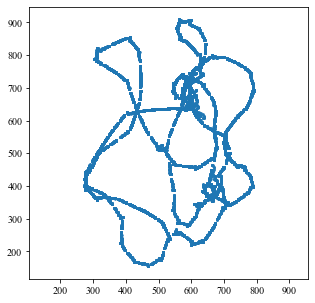

In [5]:
rec=105
plt.figure(figsize=(5,5))
print(rec)
st = 0
en = 200#lengths[rec]
X_toplot = X_head_allcond[rec,st:en,:,0]
Y_toplot = X_head_allcond[rec,st:en,:,1]
print(X_toplot.shape)
plt.scatter(ma.hstack(X_toplot),ma.hstack(Y_toplot),alpha=.75,s=3.)#,c = colors_,s = 3., cmap='coolwarm_r', norm=divnorm)
plt.axis('equal')
plt.show()

In [8]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

In [9]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked

In [10]:
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [11]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [12]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)

In [13]:
# Load eigenfunctions

# eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

# Uncomment to discover eigenfunctions and eigenvalues from ensemble transition matrix. 
# The estimation of eigenvalues is done through ARPACK, which is stochastic in nature. 
# This can result in the eigenvectors flipping sign. 
# If that happens, you can change the random seed in op_calc.sorted_spectrum()

# from scipy.sparse import diags,identity,coo_matrix, csr_matrix
# P_ensemble = csr_matrix(P_ensemble)

# import msmtools.estimation as msm_estimation
# delay = 3
# dt = 1
# print(delay)
# # lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
# R = op_calc.get_reversible_transition_matrix(P_ensemble)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123) 
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked

3


In [15]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [17]:
phi_1 = distorted_eigfs[:,0]
phi_2 = distorted_eigfs[:,1]
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

In [24]:
X_head_allcond[X_head_allcond==0] = ma.masked

In [16]:
f = h5py.File(path_to_filtered_data+'pool_ex8_PCs.h5','r')
lengths_data = np.array(f['MetaData/lengths_data'], dtype=int)
pca_fish = ma.array(f['pca_fish'])
data_means = ma.array(f['data_means'])
eigvecs = ma.array(f['eigvecs'])
cov = ma.array(f['cov'])
var_exp = np.array(f['var_exp'])
max_shuffs = np.array(f['max_shuffs'])
f.close()
data_m = ma.mean(ma.concatenate(data_means,axis=0),axis=0)

In [19]:
eigvecs = 180*(eigvecs/np.pi)

In [20]:
def rec_bout(pca_load,eigvecs,data_m):
    reconstruct_bouts = ma.dot(pca_load[:20],eigvecs[:,:20].T) + data_m
    return reconstruct_bouts.reshape(175,8)[:,-1]

In [21]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

In [22]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


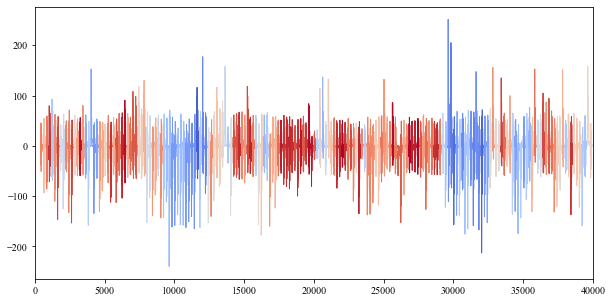

(200, 175)


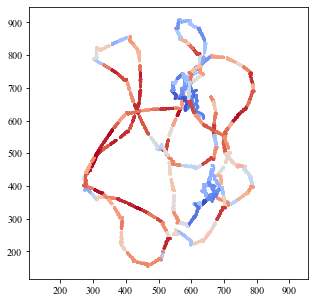

In [26]:
rec=105
mode=0
st = 0
en = 200#lengths[rec]
# print(eigfish[rec].compressed().shape)
colors_ = distorted_fish[rec][st:en,mode]
colors_ = ma.repeat(colors_[:,np.newaxis],X_head_allcond.shape[2],axis=1)

plt.figure(figsize=(10,5))
for kt in range(st,en):
    plt.plot(np.arange(200*kt,200*kt+175),rec_bout(pca_fish[rec,kt],eigvecs,data_m),c=get_colors(colors_[kt][0],plt.cm.coolwarm_r,-1,1),lw=1)#,cmap='coolwarm_r', norm=divnorm)
plt.xlim(0,40000)
plt.show()

plt.figure(figsize=(5,5))
X_toplot = X_head_allcond[rec,st:en,:,0]
Y_toplot = X_head_allcond[rec,st:en,:,1]
print(X_toplot.shape)
plt.scatter(ma.hstack(X_toplot),ma.hstack(Y_toplot),alpha=.75,c = colors_,s = 3., cmap='coolwarm_r')#, norm=divnorm)
plt.axis('equal')
plt.show()

In [27]:
reconstruct_bouts = ma.dot(pca_fish[105,1520,:20],eigvecs[:,:20].T) + data_m

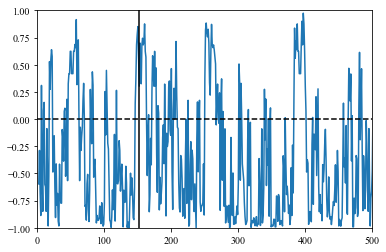

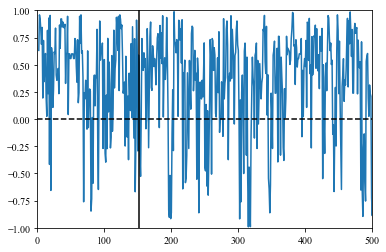

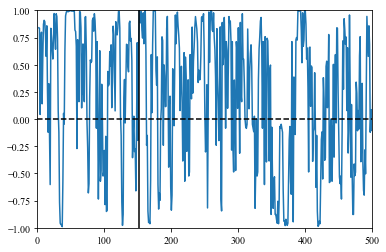

In [28]:
kf = 105
plt.plot(distorted_fish[kf][:,0],lw=1.5)
plt.xlim(0,500)
plt.ylim(-1,1)
plt.axhline(0,ls='--',c='k')
plt.axvline(151,c='k')
plt.savefig('phi1traj_rec_105.pdf')
plt.show()

plt.plot(distorted_fish[kf][:,1],lw=1.5)
plt.xlim(0,500)
plt.ylim(-1,1)
plt.axhline(0,ls='--',c='k')
plt.axvline(151,c='k')
plt.savefig('phi2traj_rec_105.pdf')
plt.show()


plt.plot(distorted_fish[kf][:,2],lw=1.5)
plt.xlim(0,500)
plt.ylim(-1,1)
plt.axhline(0,ls='--',c='k')
plt.axvline(151,c='k')
plt.savefig('phi3traj_rec_105.pdf')
plt.show()

In [29]:
def rec_bout_all(pca_load,eigvecs,data_m):
    reconstruct_bouts = ma.dot(pca_load[:20],eigvecs[:,:20].T) + data_m
    return reconstruct_bouts.reshape(175,8)

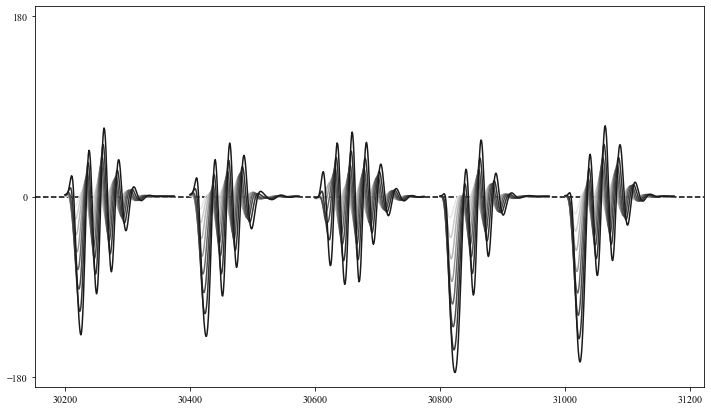

In [30]:
plt.figure(figsize=(12,7))
rec=105
b0=151
plt.axhline(0,c='k',ls='--')
for kt in range(b0,b0+5):
    bout = rec_bout_all(pca_fish[rec,kt],eigvecs,data_m)
    for kd in range(bout.shape[1]):
        plt.plot(np.arange(200*kt,200*kt+175),bout[:,kd],c='{:.1f}'.format(.95-.125*kd))
plt.ylim(-190,190)
plt.yticks([-180,0,180])
# plt.savefig('example_bout_seq.pdf')
plt.show()

In [33]:
def get_symbol_seq(eigtraj):
    symb_seq = ma.zeros(eigtraj.shape[0],dtype=int)
    symb_seq[eigtraj>0]=1
    symb_seq[eigtraj.mask] = ma.masked
    return symb_seq

4.901423818453773 4.666026209228064 5.131188313342145
4.33072249107216 4.062631061699506 4.605419224501685
3.245882433811004 3.171800266887914 3.3271364923199034
2.350519577284091 2.3215623709971083 2.3804113253150154


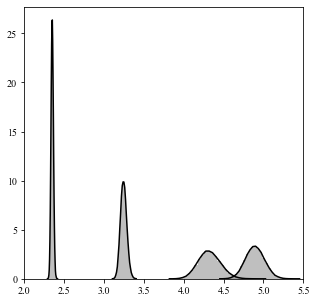

In [34]:
plt.figure(figsize=(5,5))
n_times=100000
lambda2s=np.zeros((5,3))
for keig in range(4):
    mean_states = np.zeros((distorted_fish.shape[0],2))
    for kf in range(distorted_fish.shape[0]):
        durs,_ = stats.state_lifetime(get_symbol_seq(distorted_fish[kf,:,keig]),1)
        mean_states[kf] = [np.mean(durs[k]) for k in range(2)]
#     print(mean_states)
    lambda2_est=[]
    for k in range(n_times):
        sample = mean_states[np.random.randint(0,len(distorted_fish),len(distorted_fish))].mean(axis=0)
        lambda2_est.append(2/(1/sample[0]+1/sample[1]))
    mean_all = 2/(1/mean_states.mean(axis=0)[0]+1/mean_states.mean(axis=0)[1])
    cil = np.percentile(lambda2_est,2.5)
    ciu = np.percentile(lambda2_est,97.5)
    freqs,bin_edges = np.histogram(lambda2_est,bins=30,density=True)
    centers = (bin_edges[1:]+bin_edges[:-1])/2
    plt.plot(centers,freqs,c='k')
    plt.bar(centers,freqs,np.diff(bin_edges)[0],alpha=.5,facecolor='gray')
#     x,y = stats.cumulative_dist(lambda2_est,(0,10))
#     plt.plot(x,y)
#     plt.scatter(np.random.normal(keig,.05,n_times),lambda2_est,c='gray',alpha=.5,s=.5)
    lambda2s[keig] = [mean_all,cil,ciu]
    print(mean_all,cil,ciu)
# plt.scatter(np.arange(5),-3/np.log(eigvals[:5]),c='k')
# plt.errorbar(np.arange(5),lambda2s[:,0],yerr = [lambda2s[:,0]-lambda2s[:,1],lambda2s[:,2]-lambda2s[:,0]],fmt='o',capsize=3)
# plt.ylim(0,1)
plt.xlim(2,5.5)
# plt.savefig('bootstrap_tscales_hist_modes_black.pdf')
plt.show()